### Simulation setup
TRAPPIST-1 planet data from Huang & Ormel (2022):
<center>
<img width=500 src="./Figures/trappist1_data.png"></img>
</center>

In [ ]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"

# Add the star
sim.add(m=0.09)

# Define planet masses (converted to Msun), semi‐major axes (AU), and eccentricities
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * 3.003e-6
a0 = np.array([1.154, 1.580, 2.227, 2.925, 3.849, 4.683, 6.389]) * 0.01 # h is shifted out by 3%
e0 = np.array([0.004, 0.002, 0.006, 0.0065, 0.009, 0.004, 0.0035])
num_planets = len(masses)

# Add planets
for m, a, e in zip(masses, a0, e0):
    sim.add(m=m, a=a, e=e)

# Move to center of momentum
sim.move_to_com()
ps = sim.particles

### Disk Parameters
From Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_parameters.png"></img>
</center>

In [ ]:
# Free parameters
tau_a_earth = 20000
C_e = 0.5
r_c = 0.02
A_a = 100
A_e = 20

# Other parameters
h = 0.03
M_g_dot = 10e-10
M_star = 0.09
gamma_I = 2
tau_d = 1e5
Delta = 2*h*r_c
Q_sim = 100

### Reboundx forces
We add the following forces using `REBOUNDx`:
- `type_I_migration`
- `modify_orbits_forces`
- `tides_constant_time_lag`

In [ ]:
rebx = reboundx.Extras(sim)

# type I migration
mig = rebx.load_force("type_I_migration")
rebx.add_force(mig)

# Orbital damping
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

# Tidal damping
tides = rebx.load_force("tides_constant_time_lag")
rebx.add_force(tides)

For type I migration, we require

* The disk scale height in code units (here AU), 1 code unit from the central star ($h_1$) 
* The disk surface density 1 code unit from the central star ($\Sigma_1$) 
* The disk surface density exponent ($\alpha$), assuming a power law $\Sigma(r) = \Sigma_1 r^{-\alpha}$, where $r$ is the radial distance from the star in code units
* The disk flaring index ($\beta$), assuming a power-law scale height $h(r) = h_1 r^\beta$

In [ ]:


# mig.params["tIm_scale_height_1"] = 0.03
# mig.params["tIm_surface_density_1"] = 1.1e-4 # 1000 g/cm^2 surface density in Msun/AU^2
# mig.params["tIm_surface_density_exponent"] = 1
# mig.params["tIm_flaring_index"] = 0.25







### Adding an inner disk edge (ide) to halt migration
An artificial prescription for halting the planet at `ide_position` (in AU). 

We also have to set the 'width' of the ide. This is the width of the region in which the migration torque flips sign, so the planet will stop within this distance scale of the inner disk edge's location. 

Here we set the width to the scale height of the disk at the inner disk edge:

In [ ]:
# mig.params["ide_position"] = 0.02
# mig.params["ide_width"] = mig.params["tIm_scale_height_1"]*mig.params["ide_position"]**mig.params["tIm_flaring_index"]
# print('Planet will stop within {0:.3f} AU of the inner disk edge at {1} AU'.format(mig.params["ide_width"], mig.params["ide_position"]))

### Orbital damping
We calculate the semi-major axis damping timescale and eccentricity damping timescale based on these equations from Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_timescales.png"></img>
</center>

In [ ]:
q_vals = masses / M_star
q_gas = Sigma_g * a0**2 / M_star

# Piecewise functions f_a and f_e
conditions = [
    r < r_c - Delta,
    (r_c - Delta <= r) & (r < r_c),
    (r_c < r) & (r < r_c + Delta + 1 / A_a),
    r > r_c + Delta + 1 / A_a
]

functions_a = [
    0,          
    A_a * (r_c - Delta - r) / Delta,
    A_a * (r - r_c - Delta) / Delta,
    1
]

functions_e = [
    0,          
    A_e * (r - r_c - Delta) / Delta,
    (A_e - 1) * (r_c + Delta + 1 / A_a - r) / (Delta + 1 / A_a) + 1,
    1
]

f_a_vals = np.select(conditions, functions_a, default=np.nan)
f_e_vals = np.select(conditions, functions_e, default=np.nan)

for i, p in enumerate(ps[1:]): # could try to only damp semi-major axis of planet h
    p.params["tau_a"] = -(h^2 / f_a) / (2 * gamma_I * q_vals[i] * q_gas * Omega_K) # negative so it is damping
    
for p in ps[1:]: # skip star at index 0
    p.params["tau_e"] = -C_e * h**2 * tau_a_vals[i] * f_a / f_e

We set the timestep to 5% of the orbital period of Planet b to make sure we always resolve the orbit

In [326]:
sim.integrator = 'whfast'
sim.dt = ps[1].a**(3/2)/20
print(sim.dt)
sim.dt = 0.001

6.198387419321256e-05


### Integrate and Record

In [ ]:
time_steps = 1000
times = np.linspace(0, 2000, time_steps)

a_vals = np.zeros((num_planets, time_steps))
e_vals = np.zeros((num_planets, time_steps))
n_vals = np.zeros((num_planets, time_steps))
P_vals = np.zeros((num_planets, time_steps))
P_ratios = np.zeros((num_planets - 1, time_steps))

for i, t in enumerate(times):
    sim.integrate(t)
    for j, p in enumerate(ps[1:]):  # skip the star
        a_vals[j, i] = p.a
        e_vals[j, i] = p.e
        n_vals[j, i] = np.sqrt(sim.G * ps[0].m / p.a**3) 
        P_vals[j, i] = 2 * np.pi / n_vals[j, i]
    for j, p in enumerate(ps[1:7]):  # first 6 planet pairs
        P_ratios[j, i] = P_vals[j+1, i] / P_vals[j, i]

### Plotting

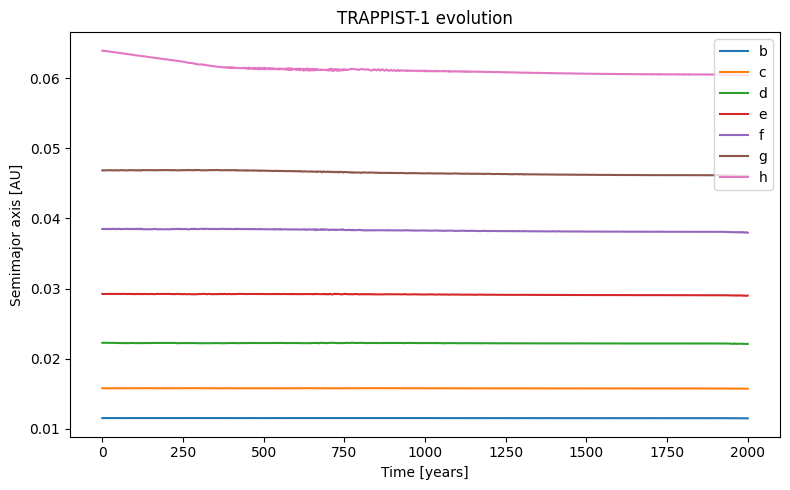

In [ ]:
plt.figure(figsize=(8,5))
for j in range(len(masses)):
    # could also try plotting log
    plt.plot(times, a_vals[j], label=f'{chr(98+j)}')  # b, c, d, ...
plt.xlabel("Time (years)")
plt.ylabel("Semimajor axis (AU)")
# plt.ylabel("Eccentricity")

plt.title("TRAPPIST-1 evolution")
plt.legend()
plt.tight_layout()
plt.show()

### Resonance Ratios

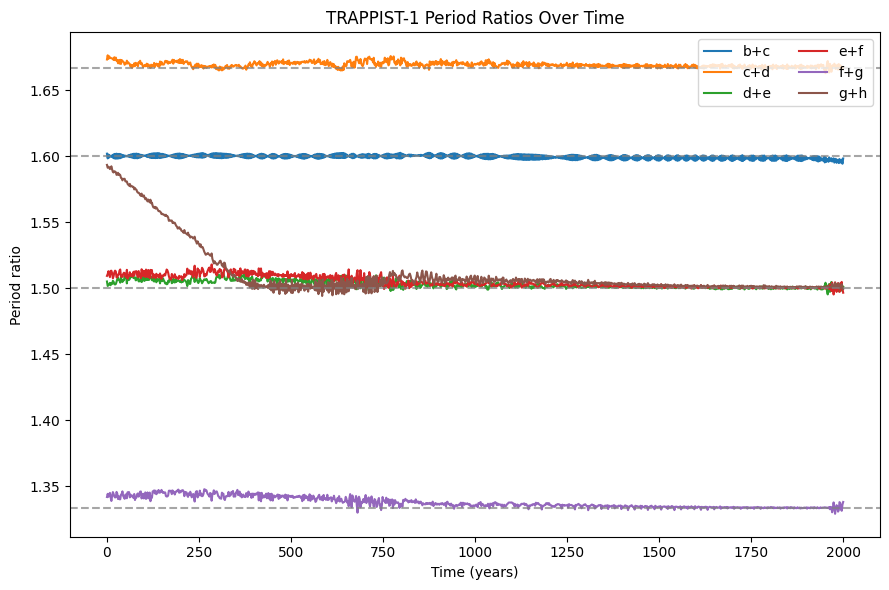

In [332]:
plt.figure(figsize=(9,6))
labels = [f"{chr(98+j-1)}+{chr(98+j)}" for j in range(1, 7)]  # b,c,d,...
for j in range(6):
    plt.plot(times, P_ratios[j], label=labels[j])

# Add horizontal lines for nearby resonances
resonances = [8/5, 5/3, 3/2, 4/3]
for r in resonances:
    plt.axhline(r, color='gray', ls='--', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Period ratio")
plt.title("TRAPPIST-1 Period Ratios Over Time")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


### Check for resonance
Using the formula $(p+q)\lambda_2 - p\lambda_1 - q \varpi_1$.

### Calculating Laplace coefficients

In [330]:
# from pylaplace import LaplaceCoefficient

# alpha = 0.9   # a1/a2
# l = LaplaceCoefficient(alpha)
# b_12_1 = l.b(1/2, 1)    # b_{1/2}^{(1)}(α)
# b_32_2 = l.b(3/2, 2)    # b_{3/2}^{(2)}(α)
# print(b_12_1, b_32_2)